In [ ]:
!gdown "1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96" -O "tumor_dataset.rar"

Downloading...
From: https://drive.google.com/uc?id=1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96
To: /content/tumor_dataset.rar
100% 317M/317M [00:01<00:00, 216MB/s]


In [ ]:
!pip install unrar -q

In [ ]:
!rm -rf "/content/tumor_dataset"
!unrar x "tumor_dataset.rar" &> /dev/null

In [ ]:
!ls -l "/content/tumor_dataset/Glioma/" | wc -l
!ls -l "/content/tumor_dataset/Meningioma" | wc -l
!ls -l "/content/tumor_dataset/Pituitary/" | wc -l

1427
709
931


In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


In [ ]:
# Enable GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('[device]', device)

[device] cuda


In [ ]:

dataset_path = "/content/tumor_dataset"
image_size = (224, 224)
# Load and preprocess the dataset
classes = ["Glioma", "Meningioma", "Pituitary"]

images_path = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        images_path.append(image_path)
        labels.append(i)

# Convert the lists to numpy arrays
images_path = np.array(images_path)
labels = np.array(labels)

print('[images_path]', len(images_path), images_path[0], images_path[-1])
print('[labels]', len(labels), labels[:10], labels[-10:])

# Create the train-test split
train_images_path, test_images_path, train_labels, test_labels = train_test_split(images_path, labels, test_size=0.2, stratify=labels, random_state=42)

print('[train_images_path]', len(train_images_path), train_images_path[0], train_images_path[-1])
print('[train_labels]', len(train_labels), train_labels[:10], train_labels[-10:])
print('[test_images_path]', len(test_images_path), test_images_path[0], test_images_path[-1])
print('[test_labels]', len(test_labels), test_labels[:10], test_labels[-10:])

class BrainTumorDataset(Dataset):
    def __init__(self, images_path, labels):
        self.images_path = images_path
        self.labels = labels

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        # get image path
        image_path = self.images_path[idx]
        # get image label
        label = self.labels[idx]
        # read actual image
        image = cv2.imread(image_path)
        # resize image
        image = cv2.resize(image, image_size)
        # convert to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # convert to pytorch tensor
        image = torch.from_numpy(image)
        # normalize for better performance
        image = image / 255
        # reorder according to pytorch requirements
        image = image.permute((2, 0, 1))
        return image, label

# Define Common Functions
def training_loop(train_loader, val_loader, model, optimizer, criterion, epochs, fold, device):
    # Lists to store metrics for this fold
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_predictions = []
    val_probs = []

    # Training loop for this fold
    for epoch in range(epochs):
        #################
        # TRAINING PART #
        #################
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_train_samples = len(train_loader.dataset)

        for idx, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(labels)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += sum(predicted == labels)

        average_accuracy = correct_predictions / total_train_samples
        average_loss = running_loss / total_train_samples
        print(f"[train][Fold {fold + 1}][Epoch {epoch + 1}]: Loss {average_loss}, Accuracy: {average_accuracy}")
        train_accuracies.append(average_accuracy.item())
        train_losses.append(average_loss)

        ###################
        # VALIDATION PART #
        ###################
        model.eval()
        val_loss = 0.0
        correct_val_predictions = 0

        total_val_samples = len(val_loader.dataset)

        with torch.no_grad():
            for idx, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val_predictions += sum(predicted == labels)


        average_val_accuracy = correct_val_predictions / total_val_samples
        average_val_loss = val_loss / total_val_samples
        print(f"[valid][Fold {fold + 1}][Epoch {epoch + 1}]: Loss {average_val_loss}, Accuracy: {average_val_accuracy}")
        val_accuracies.append(average_val_accuracy.item())
        val_losses.append(average_val_loss)



    model.train()

    return train_accuracies, train_losses, val_accuracies, val_losses

    # CURVES PLOTTING

def plot_macro_roc_curve(fprs, tprs, aucs):
    plt.figure()
    colors = ['red', 'green', 'blue']
    for i in range(len(fprs)):
        plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {aucs[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-averaged ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_macro_precision_recall_curve(precisions, recalls):
    plt.figure()
    colors = ['red', 'green', 'blue']
    for i in range(len(precisions)):
        plt.plot(recalls[i], precisions[i], color=colors[i], lw=2, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Macro-averaged Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

import torch.nn.functional as F
import pandas as pd

#FEATURE EXTRACTION

def extract_features(loader, model, device):

    model.eval()
    features_list = []
    labels_list = []

    def hook(model, input, output):
        features_list.append(output.detach().cpu().numpy())

    h = model.classifier[7].register_forward_hook(hook)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            labels_list.append(labels.cpu().numpy())

    h.remove()

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    print('[features_array]', features_array.shape)
    print('[labels_array]', labels_array.shape)

    return features_array, labels_array


def kfold_training_loop(train_images_path, train_labels, test_images_path, test_labels, num_folds, epochs_per_fold, batch_size):

    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    train_accuracies_list = []
    train_losses_list = []
    val_accuracies_list = []
    val_losses_list = []



    # Training loop with k-fold cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(train_images_path, train_labels)):
        print(f"Fold {fold + 1}/{num_folds}")

        # Create the train-validation split for this fold
        train_images_path_fold = train_images_path[train_index]
        train_labels_fold = train_labels[train_index]
        val_images_path_fold = train_images_path[val_index]
        val_labels_fold = train_labels[val_index]
        train_dataset = BrainTumorDataset(images_path=train_images_path_fold, labels=train_labels_fold)
        val_dataset = BrainTumorDataset(images_path=val_images_path_fold, labels=val_labels_fold)


        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2*batch_size, shuffle=False)


        # Load the pre-trained AlexNet model for each fold
        alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        alexnet.classifier[6] = nn.Dropout(0.5)
        alexnet.classifier.append(nn.Linear(4096, 64))
        alexnet.classifier.append(nn.ReLU(inplace=True))
        alexnet.classifier.append(nn.Linear(64, 3))
        alexnet.to(device)

        # Define the loss function
        criterion = nn.CrossEntropyLoss()

        # Define the optimizer, added some good practices
        optimizer = optim.Adam(alexnet.parameters(), lr=0.0001, weight_decay=0.005, amsgrad=True)

        #training loop function

        fold_train_accuracies, fold_train_losses, fold_val_accuracies, fold_val_losses = training_loop(
            train_loader=train_loader,
            val_loader=val_loader,
            model=alexnet,
            optimizer=optimizer,
            criterion=criterion,
            epochs=epochs_per_fold,
            fold=fold,
            device=device
        )

        train_accuracies_list.append(fold_train_accuracies)
        train_losses_list.append(fold_train_losses)
        val_accuracies_list.append(fold_val_accuracies)
        val_losses_list.append(fold_val_losses)

        # Calculate the average metrics for all folds
        avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
        avg_train_losses = np.mean(fold_train_losses, axis=0)
        avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)
        avg_val_losses = np.mean(fold_val_losses, axis=0)



    # Evaluate the model on test set
    alexnet.eval()
    test_predictions = []
    test_probs = []
    test_dataset = BrainTumorDataset(images_path=test_images_path, labels=test_labels)
    test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = alexnet(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.append(predicted.cpu().numpy())
            test_probs.append(torch.softmax(outputs, dim=1).detach().cpu().numpy())
    # test_predictions_list.append(test_predictions)
    test_predictions = np.concatenate(test_predictions, axis=0)
    test_probs = np.concatenate(test_probs, axis=0)
    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
    recall = recall_score(test_labels, test_predictions, average=None)
    f1 = f1_score(test_labels, test_predictions, average=None)
    confusion_metrics = confusion_matrix(test_labels, test_predictions)

    print("[test] Overall Evaluation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion_metrics:{confusion_metrics}")



    # Calculate ROC curve and AUC for each class
    fprs = []
    tprs = []
    aucs = []
    for i in range(3):
        fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
        roc_auc = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(roc_auc)

    # Calculate Precision-Recall curve for each class
    precisions = []
    recalls = []
    for i in range(3):
        precision, recall, _ = precision_recall_curve(test_labels == i, test_probs[:, i])
        precisions.append(precision)
        recalls.append(recall)

    # Plot macro-averaged ROC curve and Precision-Recall curve
    plot_macro_roc_curve(fprs, tprs, aucs)
    plot_macro_precision_recall_curve(precisions, recalls)

    # Print overall confusion matrix
    overall_confusion_matrix = confusion_matrix(test_labels, test_predictions)
    print("Overall Confusion Matrix:")
    print(overall_confusion_matrix)

    # Train Dataset Feature Extraction
    train_dataset = BrainTumorDataset(images_path=train_images_path, labels=train_labels)
    train_loader = DataLoader(train_dataset, batch_size=2*batch_size, shuffle=False)
    train_features, train_labels = extract_features(train_loader, alexnet, device)
    # Convert lists to arrays
    Alexnet_train_features = np.array(train_features)
    train_labels_list = np.array(train_labels)


    # Test Dataset Feature Extraction
    test_dataset = BrainTumorDataset(images_path=test_images_path, labels=test_labels)
    test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False)
    test_features, test_labels = extract_features(test_loader, alexnet, device)
# Convert lists to arrays
    Alexnet_test_features = np.array(test_features)
    test_labels_list = np.array(test_labels)


# Create dataframes for training and testing features with labels
    train_data = pd.DataFrame(data=Alexnet_train_features)
    train_data["label"] = train_labels_list
    test_data = pd.DataFrame(data=Alexnet_test_features)
    test_data["label"] = test_labels_list

    # Save training and testing data to CSV files
    train_data.to_csv("Alexnet_train_features.csv", index=False)
    test_data.to_csv("Alexnet_test_features.csv", index=False)



[images_path] 3064 /content/tumor_dataset/Glioma/2.0---101020-i754.bmp /content/tumor_dataset/Pituitary/3.0---104558-i1354.bmp
[labels] 3064 [0 0 0 0 0 0 0 0 0 0] [2 2 2 2 2 2 2 2 2 2]
[train_images_path] 2451 /content/tumor_dataset/Glioma/2.0---MR048297-i1848.bmp /content/tumor_dataset/Glioma/2.0---90284-i804.bmp
[train_labels] 2451 [0 0 0 0 0 1 2 0 0 0] [0 2 2 2 0 1 1 2 2 0]
[test_images_path] 613 /content/tumor_dataset/Glioma/2.0---MR029209I-i2395.bmp /content/tumor_dataset/Pituitary/3.0---112746-i1257.bmp
[test_labels] 613 [0 0 1 1 1 0 1 0 2 2] [1 1 0 0 2 1 0 0 2 2]


Fold 1/4


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [03:51<00:00, 1.06MB/s]
100%|██████████| 230/230 [00:18<00:00, 12.20it/s]


[train][Fold 1][Epoch 1]: Loss 0.5633868227091591, Accuracy: 0.7557126879692078


100%|██████████| 39/39 [00:00<00:00, 41.26it/s]


[valid][Fold 1][Epoch 1]: Loss 0.017512315115473593, Accuracy: 0.8792822360992432
Fold 2/4


100%|██████████| 230/230 [00:10<00:00, 21.21it/s]


[train][Fold 2][Epoch 1]: Loss 0.51760916066507, Accuracy: 0.7725788950920105


100%|██████████| 39/39 [00:00<00:00, 42.50it/s]


[valid][Fold 2][Epoch 1]: Loss 0.02222092743495063, Accuracy: 0.8384991884231567
Fold 3/4


100%|██████████| 230/230 [00:10<00:00, 21.07it/s]


[train][Fold 3][Epoch 1]: Loss 0.5267012159667415, Accuracy: 0.7682263255119324


100%|██████████| 39/39 [00:00<00:00, 43.04it/s]


[valid][Fold 3][Epoch 1]: Loss 0.021119913769974016, Accuracy: 0.8646003603935242
Fold 4/4


100%|██████████| 230/230 [00:10<00:00, 21.12it/s]


[train][Fold 4][Epoch 1]: Loss 0.5309065371152174, Accuracy: 0.7591082453727722


100%|██████████| 39/39 [00:00<00:00, 42.78it/s]


[valid][Fold 4][Epoch 1]: Loss 0.01966304681416041, Accuracy: 0.8790850043296814
[test] Overall Evaluation Metrics:
Accuracy: 0.8776508972267537
Precision: [0.89347079 0.79699248 0.91005291]
Recall: [0.9122807  0.74647887 0.92473118]
F1 Score: [0.90277778 0.77090909 0.91733333]
Confusion_metrics:[[260  19   6]
 [ 25 106  11]
 [  6   8 172]]


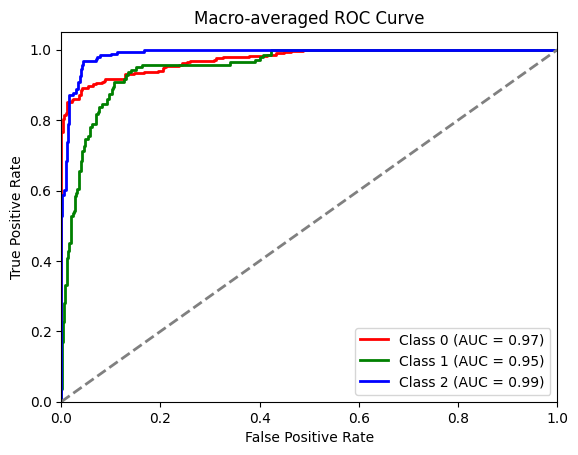

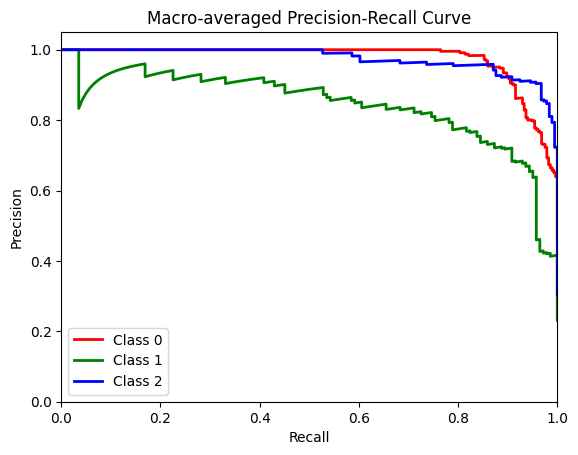

Overall Confusion Matrix:
[[260  19   6]
 [ 25 106  11]
 [  6   8 172]]
[features_array] (2451, 64)
[labels_array] (2451,)
[features_array] (613, 64)
[labels_array] (613,)


In [ ]:
kfold_training_loop(train_images_path, train_labels, test_images_path, test_labels, num_folds=4, epochs_per_fold=1, batch_size=8)


In [ ]:
# @title Default title text
models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Task P4  HOG FEATURES

In [ ]:
import os
import numpy as np
from skimage import io, transform, feature, exposure,color

dataset_path = "/content/tumor_dataset"
image_size = (256,256)
classes = ["Glioma", "Meningioma", "Pituitary"]

# Define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# Define a function to extract HOG features from an image
def extract_hog_features(image):
    image = io.imread(image)
    image = transform.resize(image, image_size)


    features = feature.hog(image, orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           block_norm='L2-Hys')

    return features

# Load and preprocess the dataset
images_path = []
labels = []

for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        images_path.append(image_path)
        labels.append(i)

# Extract HOG features for each image
hog_features = []

for image_path in images_path:
    hog_feature = extract_hog_features(image_path)
    hog_features.append(hog_feature)

# Convert lists to numpy arrays
hog_features = np.array(hog_features)
labels = np.array(labels)

print('HOG features shape:', hog_features.shape)
print('Labels shape:', labels.shape)
print('[hog_features]', len(hog_features), hog_features[0], hog_features[-1])
print('[labels]', len(labels), labels[:10], labels[-10:])



HOG features shape: (3064, 34596)
Labels shape: (3064,)
[hog_features] 3064 [0.0863252  0.         0.09889754 ... 0.10408888 0.29617513 0.29617513] [0. 0. 0. ... 0. 0. 0.]
[labels] 3064 [0 0 0 0 0 0 0 0 0 0] [2 2 2 2 2 2 2 2 2 2]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2,stratify=labels, random_state=42)



architecture = [64, 32, len(np.unique(labels))]

# Build and compile the model using TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(architecture[0], activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(architecture[1], activation='relu'),
    tf.keras.layers.Dense(architecture[2], activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the original MLP model
model.fit(X_train, y_train, epochs=5, batch_size=8, validation_split=0.2)

# Predict labels using the original MLP model
y_pred_probabilities = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Calculate accuracy
accuracy_features = accuracy_score(y_test, y_pred)
print("Accuracy :", accuracy_features)


Epoch 1/5
245/245 [==============================] - 5s 7ms/step - loss: 0.5236 - accuracy: 0.7847 - val_loss: 0.5920 - val_accuracy: 0.8004
Epoch 2/5
245/245 [==============================] - 1s 4ms/step - loss: 0.2652 - accuracy: 0.9010 - val_loss: 0.2560 - val_accuracy: 0.8982
Epoch 3/5
245/245 [==============================] - 1s 4ms/step - loss: 0.1670 - accuracy: 0.9357 - val_loss: 0.2360 - val_accuracy: 0.8982
Epoch 4/5
245/245 [==============================] - 1s 4ms/step - loss: 0.0876 - accuracy: 0.9679 - val_loss: 0.2084 - val_accuracy: 0.9165
Epoch 5/5
20/20 [==============================] - 0s 4ms/step
Accuracy : 0.8727569331158238


In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
X_train_features = intermediate_layer_model.predict(X_train)
X_test_features = intermediate_layer_model.predict(X_test)

# Save features to a CSV file
train_df = pd.DataFrame(X_train_features)
train_df['label'] = y_train
train_df.to_csv('train_features.csv', index=False)

# Save features to a CSV file
train_df = pd.DataFrame(X_test_features)
train_df['label'] = y_test
train_df.to_csv('test_features.csv', index=False)

20/20 [==============================] - 0s 4ms/step


Accuracy: 0.8727569331158238
Confusion Matrix:
[[279   5   1]
 [ 58  77   7]
 [  7   0 179]]
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.81      0.98      0.89       285
  Meningioma       0.94      0.54      0.69       142
   Pituitary       0.96      0.96      0.96       186

    accuracy                           0.87       613
   macro avg       0.90      0.83      0.84       613
weighted avg       0.89      0.87      0.86       613



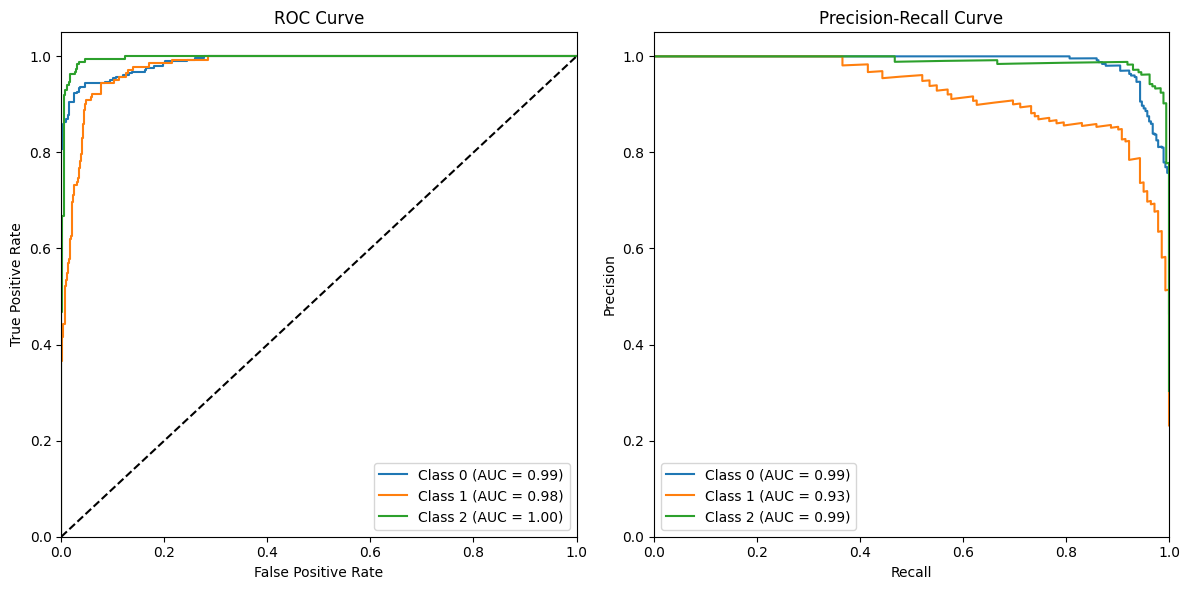

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

accuracy_features = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_features)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Calculate precision, recall, F1-score, and support for each class
classification_rep = classification_report(y_test, y_pred, target_names=classes)
print("Classification Report:")
print(classification_rep)

# Calculate ROC curve and AUC for each class
n_classes = len(classes)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate precision-recall curve and AUC for each class
precision = {}
recall = {}
pr_auc = {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred_probabilities[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot ROC and PR curves for each class
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Read data from the first CSV file (64 columns)
df1 = pd.read_csv('test_features.csv')

# Read data from the second CSV file (32 columns)
df2 = pd.read_csv('Alexnet_test_features.csv')
label_column = df2['label']
df1 = df1.drop(columns=['label'])
df2 = df2.drop(columns=['label'])

# Combine the data from both dataframes
combined_df = pd.concat([df1, df2], axis=1, ignore_index=True)


# Insert the 'label' column as the last column
combined_df.insert(len(combined_df.columns), 'label', label_column)

combined_df.to_csv('Test_combined_file.csv')

In [ ]:
import pandas as pd

# Read data from the first CSV file (64 columns)
df1 = pd.read_csv('train_features.csv')

# Read data from the second CSV file (32 columns)
df2 = pd.read_csv('Alexnet_train_features.csv')
label_column = df2['label']
df1 = df1.drop(columns=['label'])
df2 = df2.drop(columns=['label'])

# Combine the data from both dataframes
combined_df = pd.concat([df1, df2], axis=1, ignore_index=True)


# Insert the 'label' column as the last column
combined_df.insert(len(combined_df.columns), 'label', label_column)

combined_df.to_csv('Train_combined_file.csv')

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# Load the extracted features and labels from the CSV files
train_data = pd.read_csv("Train_combined_file.csv")
test_data = pd.read_csv("Test_combined_file.csv")

# Separate features and labels
train_features = train_data.drop("label", axis=1).values
train_labels = train_data["label"].values
test_features = test_data.drop("label", axis=1).values
test_labels = test_data["label"].values

# Initialize the SVM classifier
#svm_classifier = SVC(kernel='linear',C=0.1)
svm_classifier = SVC(kernel='rbf')

# Train the SVM classifier
svm_classifier.fit(train_features, train_labels)

# Predict labels using the trained SVM classifier
test_predictions = svm_classifier.predict(test_features)

# Evaluate the  classifier
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
confusion_metrics = confusion_matrix(test_labels, test_predictions)

print("[svm] Overall Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Metrics: {confusion_metrics}")


[svm] Overall Evaluation Metrics:
Accuracy: 0.46492659053833607
Precision: [0.46492659 0.         0.        ]
Recall: [1. 0. 0.]
F1 Score: [0.63474388 0.         0.        ]
Confusion Metrics: [[285   0   0]
 [142   0   0]
 [186   0   0]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# Load the extracted features and labels from the CSV files
train_data = pd.read_csv("Train_combined_file.csv")
test_data = pd.read_csv("Test_combined_file.csv")

# Separate features and labels
train_features = train_data.drop("label", axis=1).values
train_labels = train_data["label"].values
test_features = test_data.drop("label", axis=1).values
test_labels = test_data["label"].values

# Initialize and train the KNN classifier
#knn_classifier = KNeighborsClassifier(n_neighbors=27)
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed
knn_classifier.fit(train_features, train_labels)

# Make predictions on the test set
test_predictions = knn_classifier.predict(test_features)

# Evaluate the KNN classifier
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
confusion_metrics = confusion_matrix(test_labels, test_predictions)

print("[KNN] Overall Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Metrics: {confusion_metrics}")


[KNN] Overall Evaluation Metrics:
Accuracy: 0.8890701468189234
Precision: [0.93984962 0.75816993 0.92268041]
Recall: [0.87719298 0.81690141 0.96236559]
F1 Score: [0.90744102 0.78644068 0.94210526]
Confusion Metrics: [[250  32   3]
 [ 14 116  12]
 [  2   5 179]]
